Scanpy quick reference
===

Oana Ursu - 2018-09-06

Just going through the functions, trying to understand what they do.

**To run this notebook on your computer**

If you want to follow along
- download the dataset used here: the 3k PBMCs in all popular tutorials, and the data can be downloaded from http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
- change the paths below to where you downloaded the data and where the output files should be written

In [4]:
#in_path=<directory with pbmcs>/filtered_gene_bc_matrices/hg19/
#out_path=<path to output files>

in_path='/ahg/regevdata2/projects/Cell2CellCommunication/sc_explore/data/2018-05-23/filtered_gene_bc_matrices/hg19/'
out_path = '/ahg/regevdata2/projects/Cell2CellCommunication/sc_explore/results/2018-09-06_scanpy/scanpy_basics'

Import relevant packages
---

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.2.2 anndata==0.6.9 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


Reading in data
---

**1. Reading in 10X data**

In [9]:
adata = sc.read(in_path + 'matrix.mtx', cache=True).T  # transpose the data
adata.var_names = pd.read_csv(in_path + 'genes.tsv', header=None, sep='\t')[1]
adata.obs_names = pd.read_csv(in_path + 'barcodes.tsv', header=None)[0]
adata

... reading from cache file ./cache/ahg-regevdata2-projects-Cell2CellCommunication-sc_explore-data-2018-05-23-filtered_gene_bc_matrices-hg19-matrix.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2700 × 32738 

In [10]:
adata.var_names_make_unique()

In [11]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 

- obs = observations (cells)
- var = variables (genes)

**2. Reading in non-mtx data**

If you want to read expression data from a non-mtx file, you can use sc.read_text (or many others as described here https://scanpy.readthedocs.io/en/latest/api/index.html#reading). 

**IMPORTANT**: for read_text, you need the genes as columns, cells as rows.

The scanpy object (part 1)
===

Nice description here: https://scanpy.readthedocs.io/en/latest/basic_usage.html#anndata

Here is how to access different components of the gene expression data. (more on this later as well)

NOTE: This is the raw data. It might make more sense to do explore this object after filtering, normalizing, etc. the data.

**The scanpy object**

In [12]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 

**The expression data**

The expression data can be accessed as adata.X.
In this example, we have 2700 cells, and 32738 genes.

In [14]:
print(adata.X.shape)

(2700, 32738)


**Cell names and gene names**

These will be very useful for subsetting the expression data, e.g. to look at the expression of a specific set of genes, or to look at a specific subset of cells.

In [15]:
print('cell names: ',adata.obs_names[:3])
print('gene names: ',adata.var_names[:3])

cell names:  Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1'], dtype='object', name=0)
gene names:  Index(['MIR1302-10', 'FAM138A', 'OR4F5'], dtype='object')


**Example quick queries of the data**

1 | get the expression for a single gene and make a histogram across all cells.

example values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


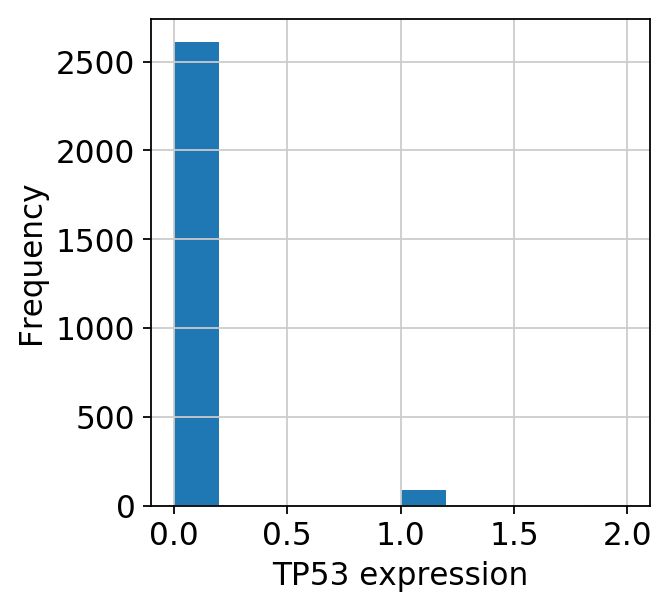

In [18]:
gene_x='TP53'
gene_x_expr=np.array(adata[:,gene_x].X)

print('example values:',gene_x_expr[:10])

plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression')
plt.ylabel('Frequency')
plt.show()

2 | get the cells that express the gene above some value

In [19]:
expr_threshold=0.5
gene_x_on_idx=np.array(adata[:,gene_x].X)>expr_threshold
cells_gene_x=adata.obs_names[gene_x_on_idx]

print('# cells with '+gene_x+' above '+str(expr_threshold)+':',len(cells_gene_x))
print('example cell names: ',cells_gene_x[:3])

# cells with TP53 above 0.5: 91
example cell names:  Index(['AAACTTGATCCAGA-1', 'AAATTCGAATCACG-1', 'AACCGATGTTCTAC-1'], dtype='object', name=0)


More operations will be displayed later, after we properly filter and normalize the data.

Basic filtering
==

Not much to explain here :)

In [20]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [21]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

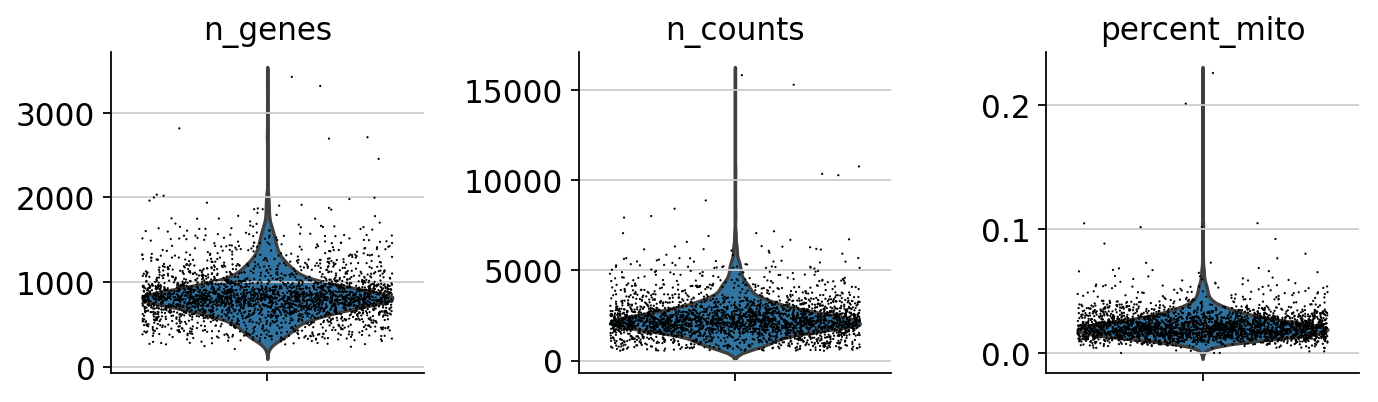

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

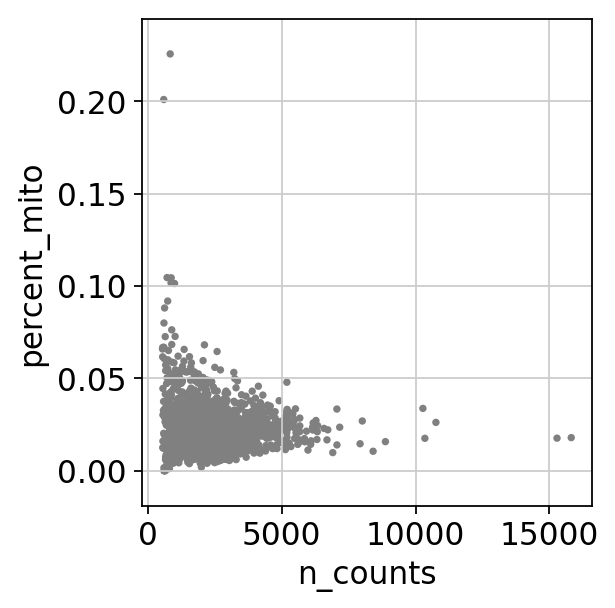

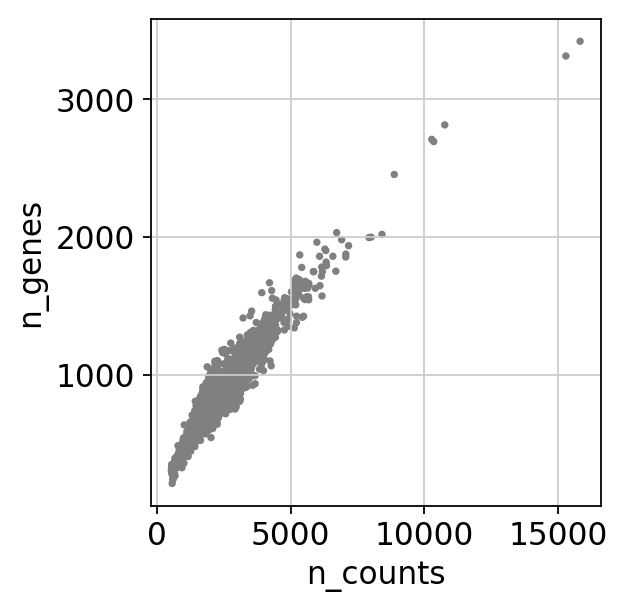

In [23]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [24]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

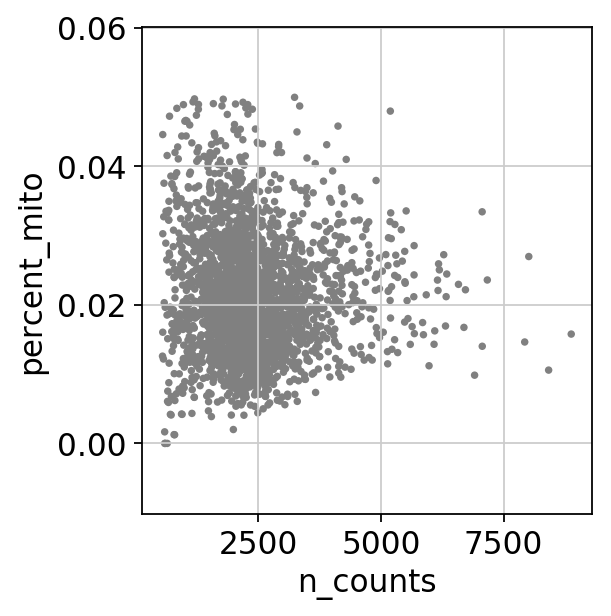

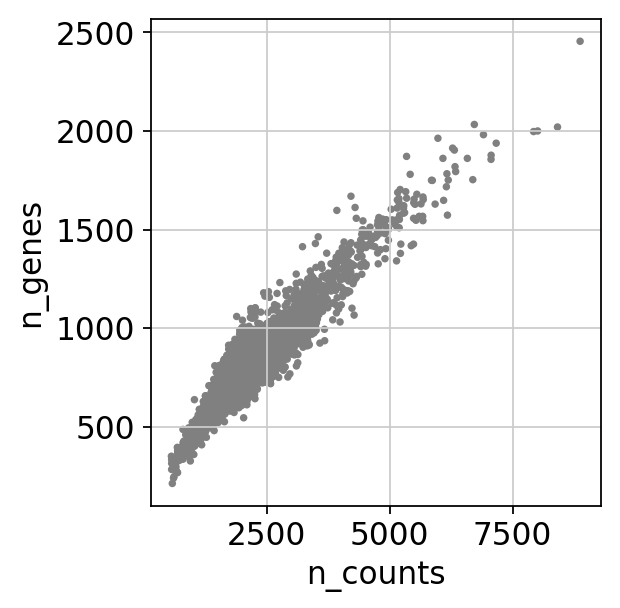

In [25]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

sc.pp.log1p 
==

https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.log1p.html?highlight=log1p

Computes X = log(X + 1), where log denotes the natural logarithm

uses method log1p from numpy: https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html, base e

In [153]:
print(np.log1p(2))
print(np.exp(np.log1p(2)))
print(np.exp(np.log(2+1)))

1.0986122886681096
2.9999999999999996
3.0000000000000004


From the tutorial: "Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p"

In [154]:
adata.raw = sc.pp.log1p(adata, copy=True)

In [155]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [156]:
adata.raw

this does **NOT** replace the values in **adata** with the log1p, but rather gives you an object, **adata.raw** that has the log1p values.

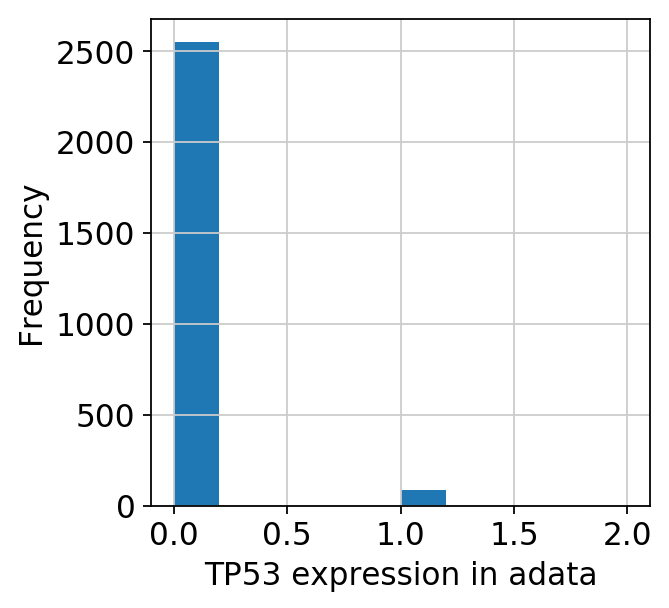

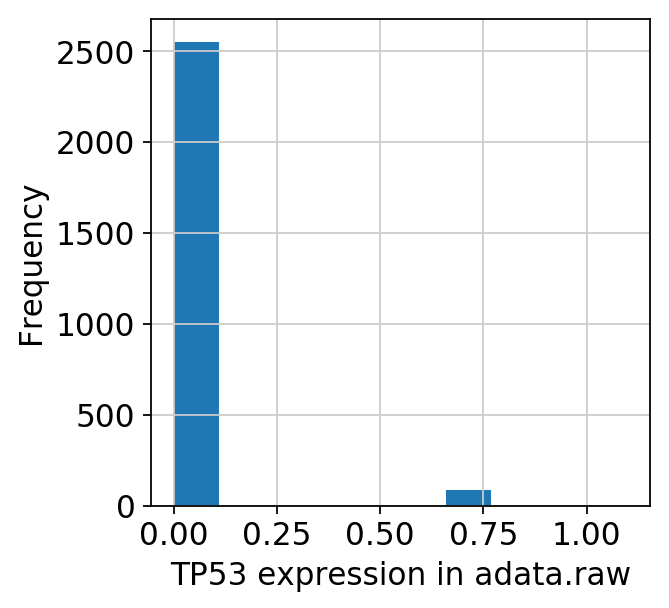

In [157]:
gene_x='TP53'

gene_x_expr=np.array(adata[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=np.array(adata.raw[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata.raw')
plt.ylabel('Frequency')
plt.show()

sc.pp.normalize_per_cell
===

From the method in the code:

    """Normalize total counts per cell.
    Normalize each cell by total counts over all genes, so that every cell has
    the same total count after normalization.
    Similar functions are used, for example, by Seurat [Satija15]_, Cell Ranger
    [Zheng17]_ or SPRING [Weinreb17]_.

    >>> adata = AnnData(
    >>>     data=np.array([[1, 0], [3, 0], [5, 6]]))
    >>> print(adata.X.sum(axis=1))
    [  1.   3.  11.]
    >>> sc.pp.normalize_per_cell(adata)
    >>> print(adata.obs)
    >>> print(adata.X.sum(axis=1))
       n_counts
    0       1.0
    1       3.0
    2      11.0
    [ 3.  3.  3.]
    >>> sc.pp.normalize_per_cell(adata, counts_per_cell_after=1,
    >>>                          key_n_counts='n_counts2')
    >>> print(adata.obs)
    >>> print(adata.X.sum(axis=1))
       n_counts  n_counts2
    0       1.0        3.0
    1       3.0        3.0
    2      11.0        3.0
    [ 1.  1.  1.]
    """

In [158]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata

AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

confirm that the gene expressions per cell sum to the same number after this.

[[10000.001]
 [10000.001]]


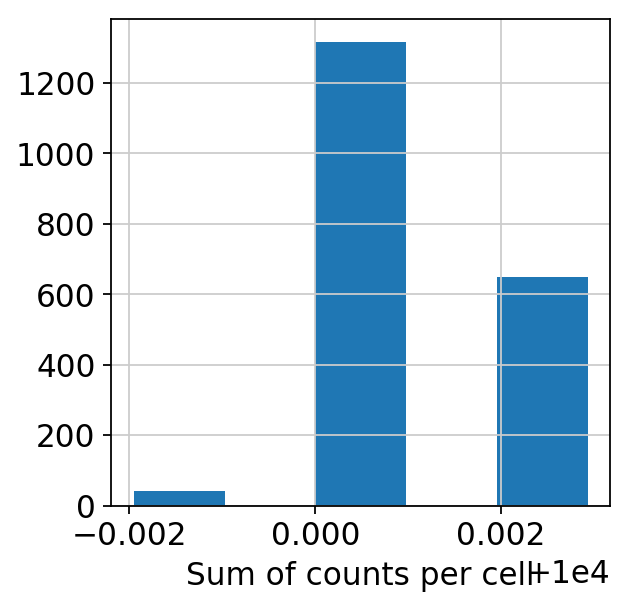

In [160]:
cell_sums=adata.X.sum(axis=1)
print(cell_sums[:2])
plt.hist(cell_sums)
plt.xlabel('Sum of counts per cell')
plt.show()

Close enough.

**Important**: Now, we need to re-compute the log1p values though.

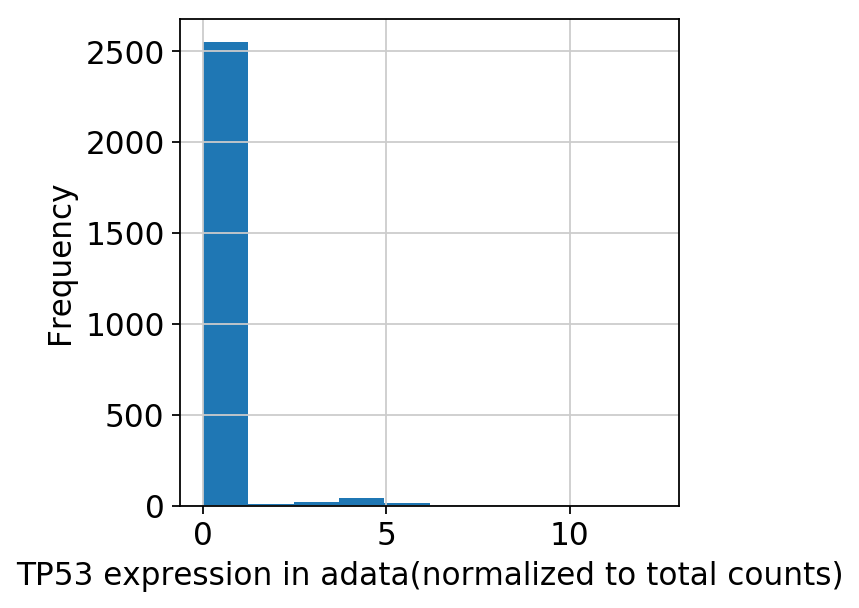

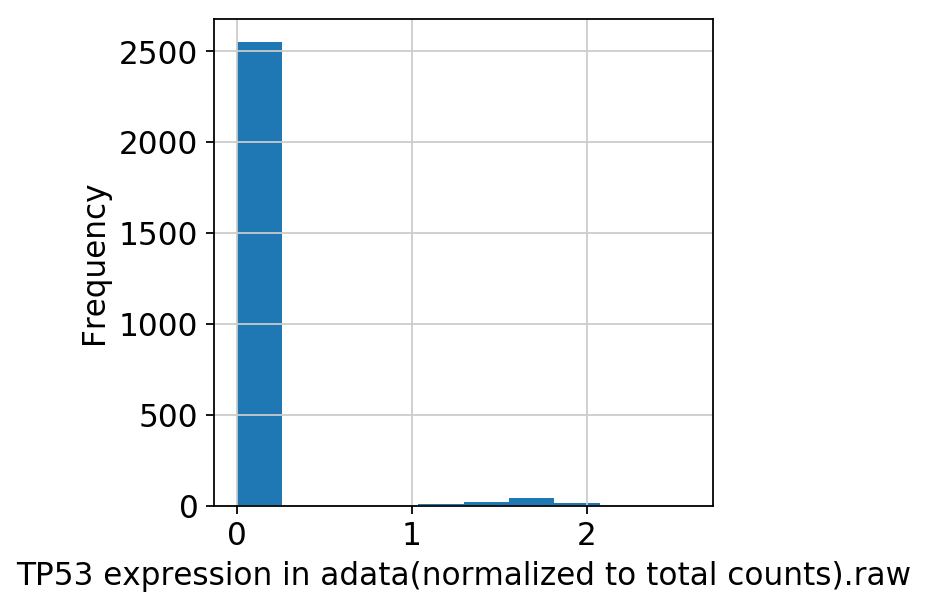

In [162]:
adata.raw = sc.pp.log1p(adata, copy=True)
gene_x='TP53'

gene_x_expr=np.array(adata[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts)')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=np.array(adata.raw[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts).raw')
plt.ylabel('Frequency')
plt.show()

Variable genes
===

From method:

    """Extract highly variable genes [Satija15]_ [Zheng17]_.
    If trying out parameters, pass the data matrix instead of AnnData.
    Depending on `flavor`, this reproduces the R-implementations of Seurat
    [Satija15]_ and Cell Ranger [Zheng17]_.
    The normalized dispersion is obtained by scaling with the mean and standard
    deviation of the dispersions for genes falling into a given bin for mean
    expression of genes. This means that for each bin of mean expression, highly
    variable genes are selected.
    Use `flavor='cell_ranger'` with care and in the same way as in
    :func:`~scanpy.api.pp.recipe_zheng17`.
    
        Parameters
    ----------
    data : :class:`~anndata.AnnData`, `np.ndarray`, `sp.sparse`
        The (annotated) data matrix of shape `n_obs` × `n_vars`. Rows correspond
        to cells and columns to genes.
    flavor : {'seurat', 'cell_ranger'}, optional (default: 'seurat')
        Choose the flavor for computing normalized dispersion. If choosing
        'seurat', this expects non-logarithmized data - the logarithm of mean
        and dispersion is taken internally when `log` is at its default value
        `True`. For 'cell_ranger', this is usually called for logarithmized data
        - in this case you should set `log` to `False`. In their default
        workflows, Seurat passes the cutoffs whereas Cell Ranger passes
        `n_top_genes`.
    min_mean=0.0125, max_mean=3, min_disp=0.5, max_disp=`None` : `float`, optional
        If `n_top_genes` unequals `None`, these cutoffs for the means and the
        normalized dispersions are ignored.
    n_bins : `int` (default: 20)
        Number of bins for binning the mean gene expression. Normalization is
        done with respect to each bin. If just a single gene falls into a bin,
        the normalized dispersion is artificially set to 1. You'll be informed
        about this if you set `settings.verbosity = 4`.
    n_top_genes : `int` or `None` (default: `None`)
        Number of highly-variable genes to keep.
    log : `bool`, optional (default: `True`)
        Use the logarithm of the mean to variance ratio.
    copy : `bool`, optional (default: `False`)
        If an :class:`~anndata.AnnData` is passed, determines whether a copy
        is returned.
    Returns
    -------
    If an AnnData `adata` is passed, returns or updates `adata` depending on \
    `copy`. It filters the `adata` and adds the annotations
    means : adata.var
        Means per gene. Logarithmized when `log` is `True`.
    dispersions : adata.var
        Dispersions per gene. Logarithmized when `log` is `True`.
    dispersions_norm : adata.var
        Normalized dispersions per gene. Logarithmized when `log` is `True`.
    If a data matrix `X` is passed, the annotation is returned as `np.recarray` \
    with the same information stored in fields: `gene_subset`, `means`, `dispersions`, `dispersion_norm`.
    """

**tl;dr**

- what data to provide:
    - flavor='seurat' needs adata.X, and log=True (both of these are the default)
    - flavor='cell_ranger' needs adata.raw (the logarithmized data) and log=False

**seurat flavor**

-add small values to genes with mean 0.

-compute dispersion as log(var/mean). 

-compute mean as log1p(mean).

-group genes into bins by their means.

-get the normalized dispersion, done separately in each bin. in each bin of expression mean, get a zscore for the dispersion based on mean, sd of dispersion in that bin.
= (dispersion - mean dispersion in the bin)/sd dispersion in the bin

-filter by the user-defined thresholds on mean expression and **normalized** dispersion (so, look in the left plot)

#=========================================================

Sooo, the **meaning of the dispersions** in the plots are:

-normalized dispersion=z-score by expression bin

-unnormalized dispersion=dispersion computed as log(var/mean).

#=========================================================

actual code snippets (skipped some parts)

    mean[mean == 0] = 1e-12
    dispersion = var / mean
    if log:  # logarithmized mean as in Seurat
    dispersion[dispersion == 0] = np.nan
    dispersion = np.log(dispersion)
    mean = np.log1p(mean)
    # all of the following quantities are "per-gene" here
    import pandas as pd
    df = pd.DataFrame()
    df['mean'] = mean
    df['dispersion'] = dispersion

    if flavor == 'seurat':
    df['mean_bin'] = pd.cut(df['mean'], bins=n_bins)
    disp_grouped = df.groupby('mean_bin')['dispersion']
    disp_mean_bin = disp_grouped.mean()
    disp_std_bin = disp_grouped.std(ddof=1)
    # retrieve those genes that have nan std, these are the ones where
    # only a single gene fell in the bin and implicitly set them to have
    # a normalized disperion of 1
    one_gene_per_bin = disp_std_bin.isnull()
    gen_indices = np.where(one_gene_per_bin[df['mean_bin']])[0].tolist()
    if len(gen_indices) > 0:
        logg.msg(
            'Gene indices {} fell into a single bin: their '
            'normalized dispersion was set to 1.\n    '
            'Decreasing `n_bins` will likely avoid this effect.'
            .format(gen_indices), v=4)
    # Circumvent pandas 0.23 bug. Both sides of the assignment have dtype==float32,
    # but there’s still a dtype error without “.value”.
    disp_std_bin[one_gene_per_bin] = disp_mean_bin[one_gene_per_bin].values
    disp_mean_bin[one_gene_per_bin] = 0
    # actually do the normalization
    df['dispersion_norm'] = (df['dispersion'].values  # use values here as index differs
                             - disp_mean_bin[df['mean_bin']].values) \
                             / disp_std_bin[df['mean_bin']].values
                             
        max_disp = np.inf if max_disp is None else max_disp
        dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
        gene_subset = np.logical_and.reduce((mean > min_mean, mean < max_mean,
                                             dispersion_norm > min_disp,
                                             dispersion_norm < max_disp))

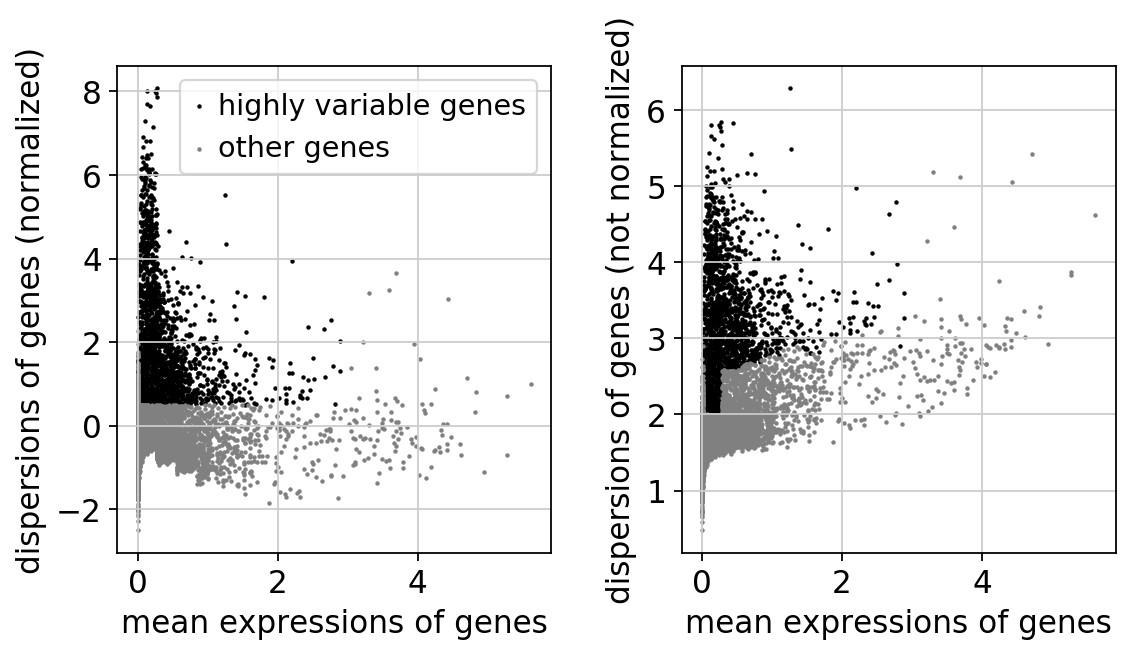

In [169]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

**cellranger flavor** 

-use the provided log1p'd data to get mean and dispersion.

-bin expression mean by percentile (10 to 105 by 5% increments)

-normalize dispersion = absolute value (dispersion - median dispersion)/sd dispersion. (again, this is computed per bin)

-you decide how many n_top_genes to get back as variable. See below what happens when this parameter is provided vs not.

#===========================

actual code snippets

        from statsmodels import robust
        df['mean_bin'] = pd.cut(df['mean'], np.r_[-np.inf,
            np.percentile(df['mean'], np.arange(10, 105, 5)), np.inf])
        disp_grouped = df.groupby('mean_bin')['dispersion']
        disp_median_bin = disp_grouped.median()
        # the next line raises the warning: "Mean of empty slice"
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disp_mad_bin = disp_grouped.apply(robust.mad)
        df['dispersion_norm'] = np.abs((df['dispersion'].values
                                 - disp_median_bin[df['mean_bin']].values)) \
                                / disp_mad_bin[df['mean_bin']].values

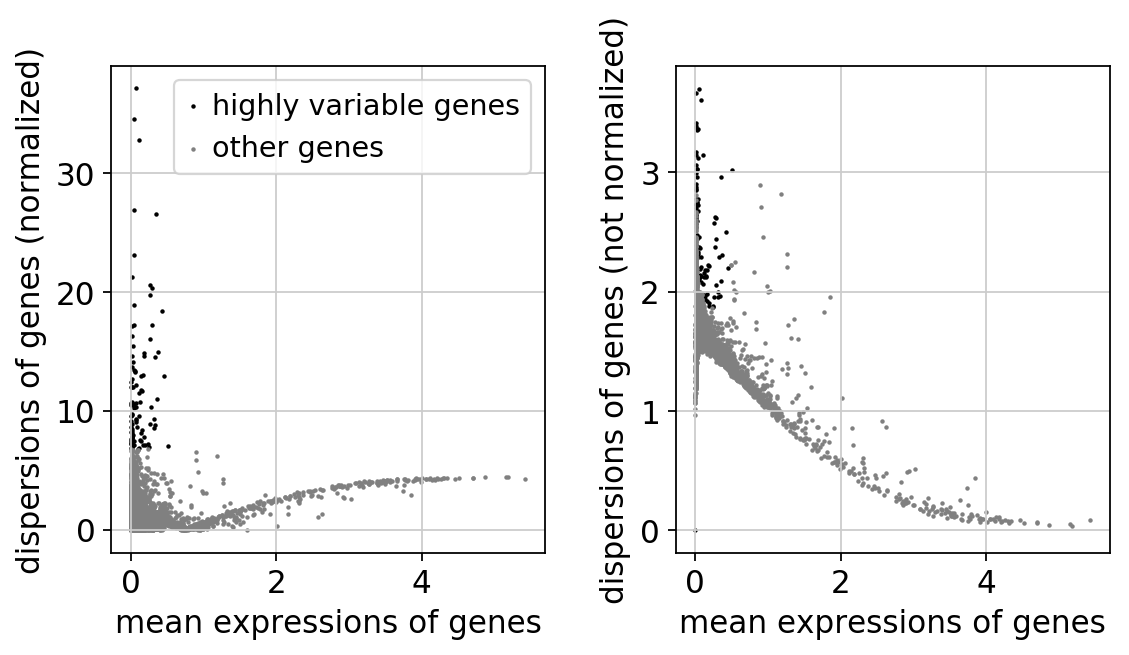

In [170]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.raw.X, flavor='cell_ranger',log=False,n_top_genes=100)
sc.pl.filter_genes_dispersion(filter_result)

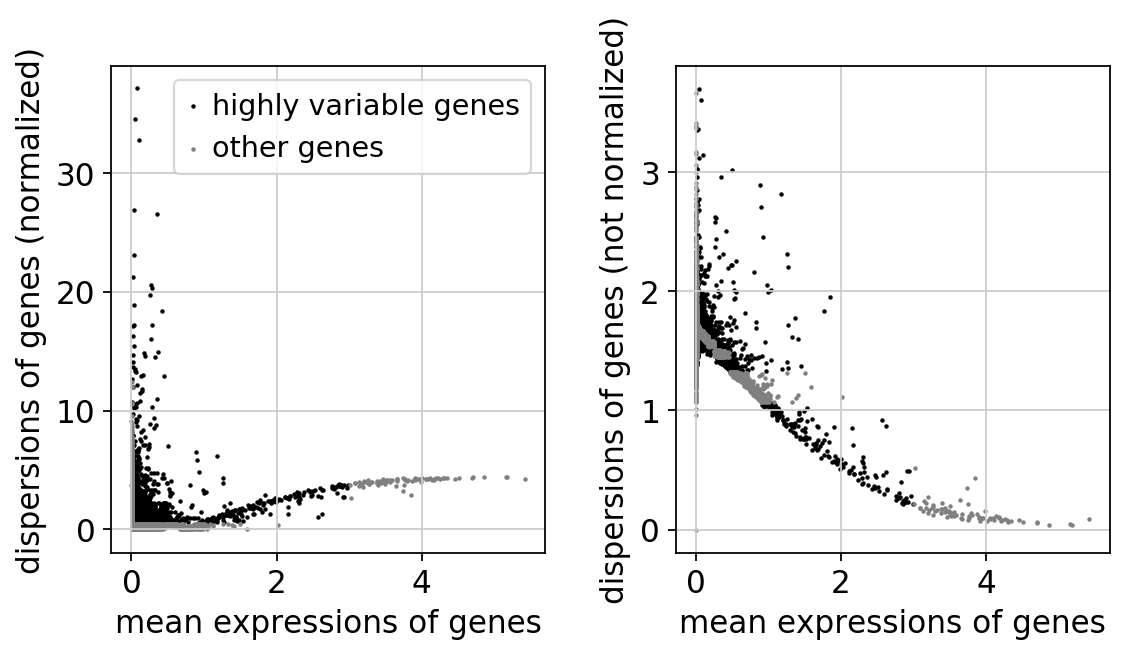

In [171]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.raw.X, flavor='cell_ranger',log=False)
sc.pl.filter_genes_dispersion(filter_result)

For the purposes of this tutorial, I will just go with the Seurat flavor.

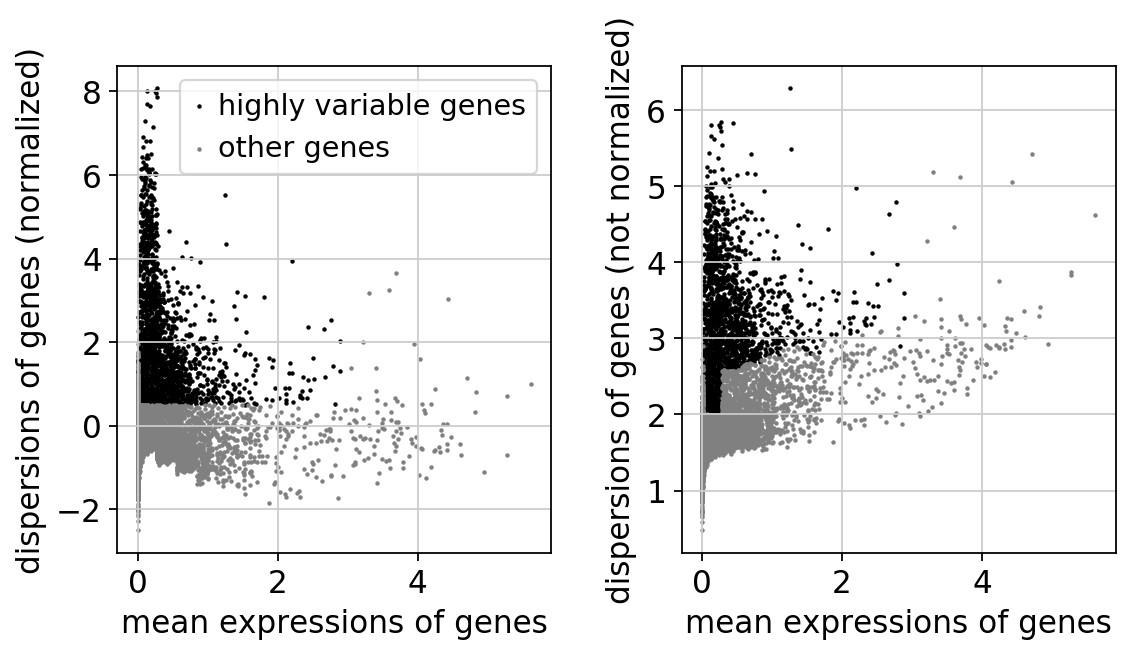

In [172]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

the above just gives you variable genes. below is the filtering.

In [173]:
adata = adata[:, filter_result.gene_subset]

In [174]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [175]:
print(adata.X.shape)

(2638, 1838)


In [179]:
print(adata.raw.X.shape) #raw not affected

(2638, 13714)


log1p the remaining data

In [180]:
sc.pp.log1p(adata)

In [183]:
print(adata.var_names[:3])

Index(['TNFRSF4', 'CPSF3L', 'ATAD3C'], dtype='object')


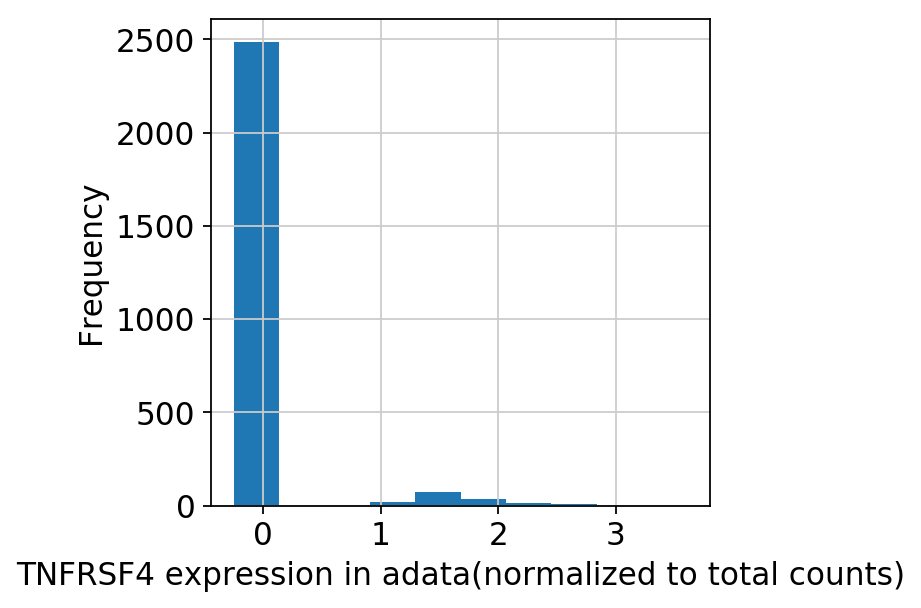

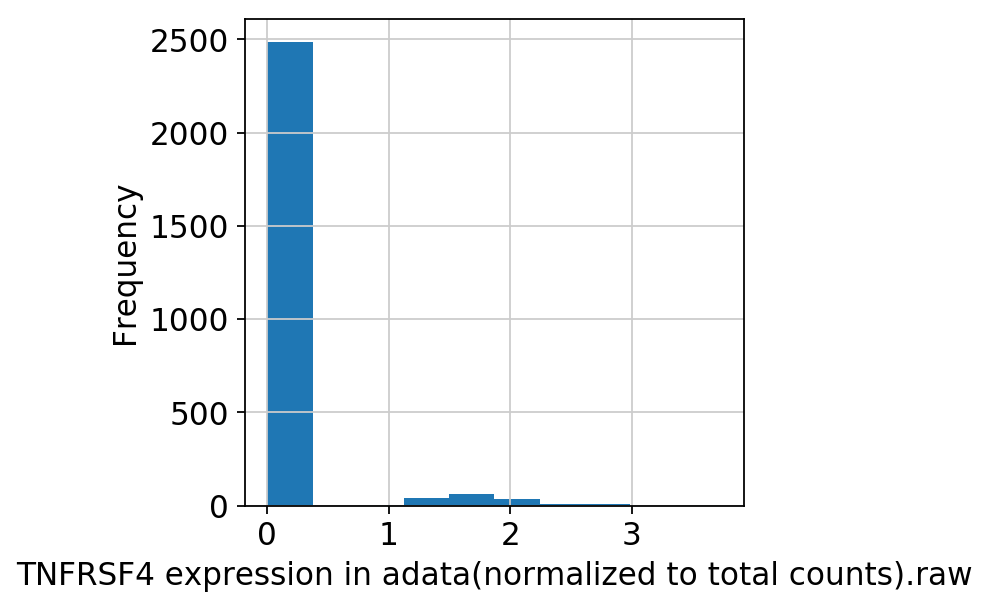

In [192]:
gene_x='TNFRSF4'

gene_x_expr=np.array(adata[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts)')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=np.array(adata.raw[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts).raw')
plt.ylabel('Frequency')
plt.show()

Regressing out stuff
===

In [185]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:09.57)


In [187]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

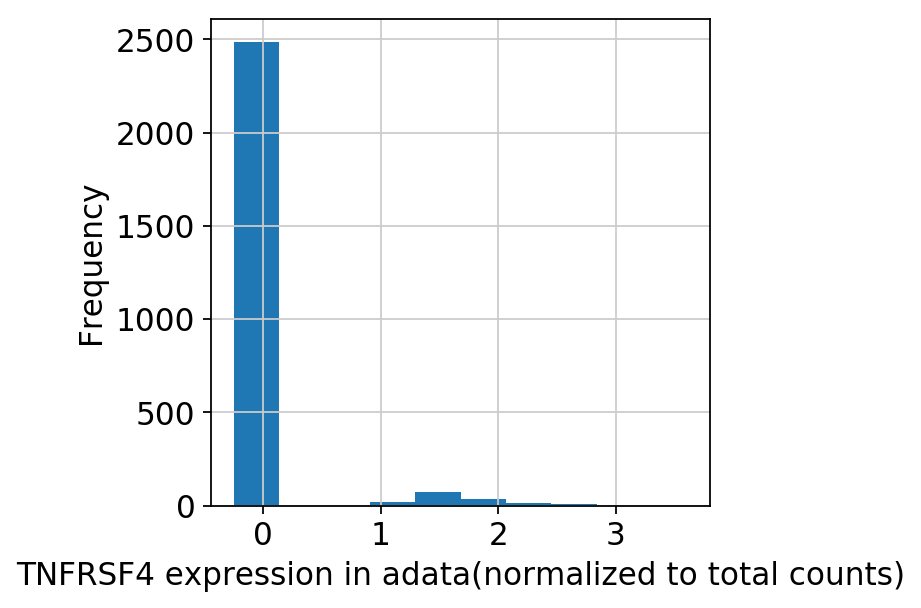

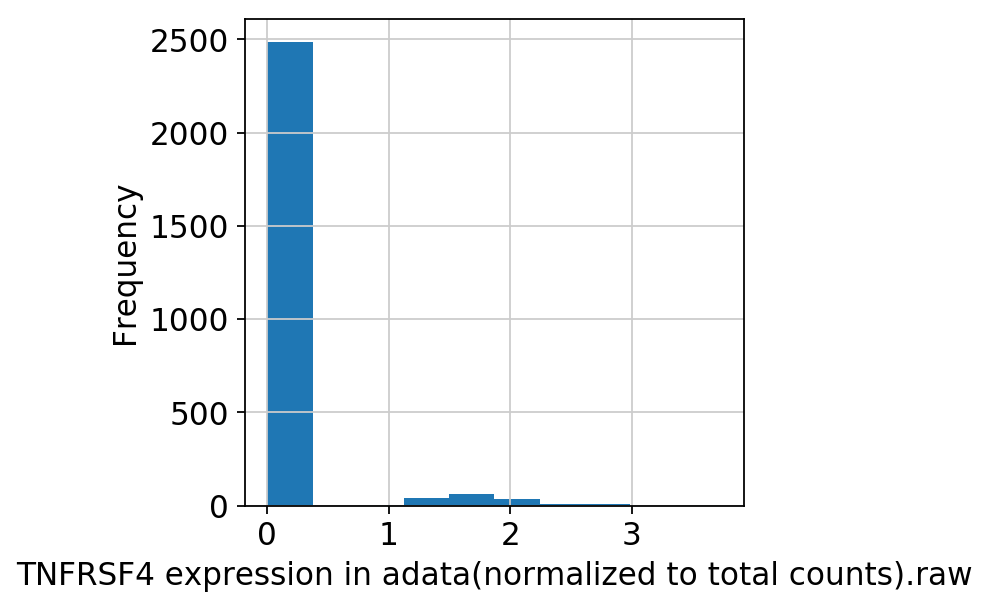

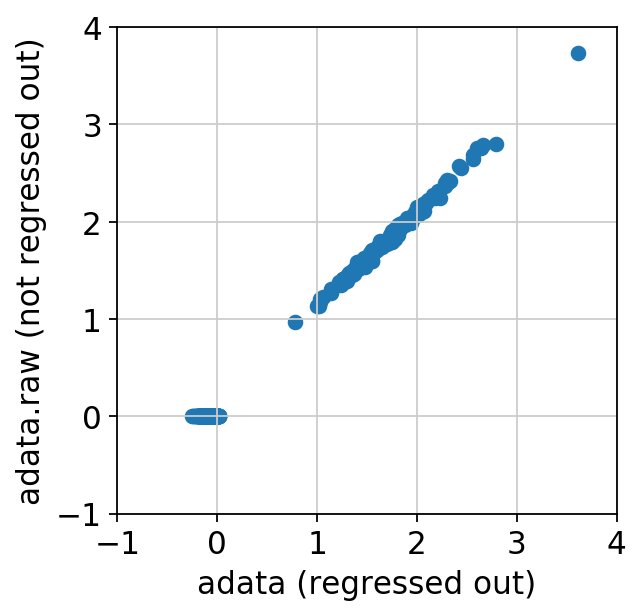

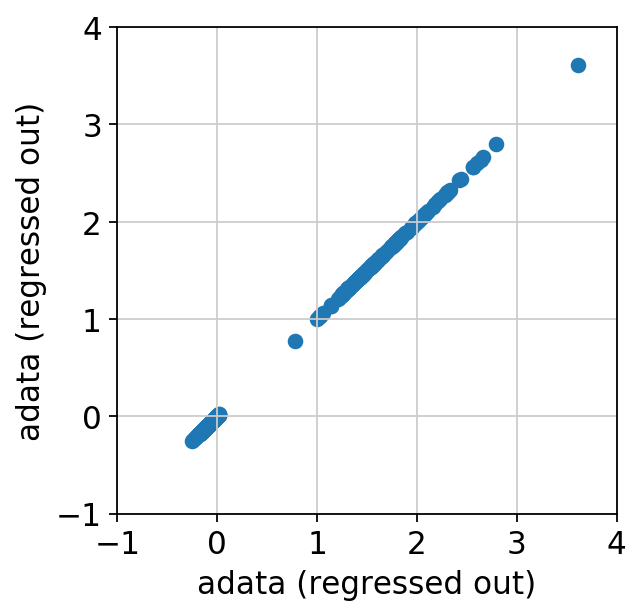

In [193]:
gene_x='TNFRSF4'

gene_x_expr=np.array(adata[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts)')
plt.ylabel('Frequency')
plt.show()

gene_x_expr=np.array(adata.raw[:,gene_x].X)
plt.hist(gene_x_expr)
plt.xlabel(gene_x+' expression in adata(normalized to total counts).raw')
plt.ylabel('Frequency')
plt.show()

plt.scatter(np.array(adata[:,gene_x].X),np.array(adata.raw[:,gene_x].X))
plt.xlabel('adata (regressed out)')
plt.ylabel('adata.raw (not regressed out)')
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.show()

plt.scatter(np.array(adata[:,gene_x].X),np.array(adata[:,gene_x].X))
plt.xlabel('adata (regressed out)')
plt.ylabel('adata (regressed out)')
plt.xlim(-1,4)
plt.ylim(-1,4)
plt.show()

So, yes, regressing out made some small changes.

sc.pp.scale
===

Scale data to unit variance and zero mean.

In [195]:
sc.pp.scale(adata, max_value=10)

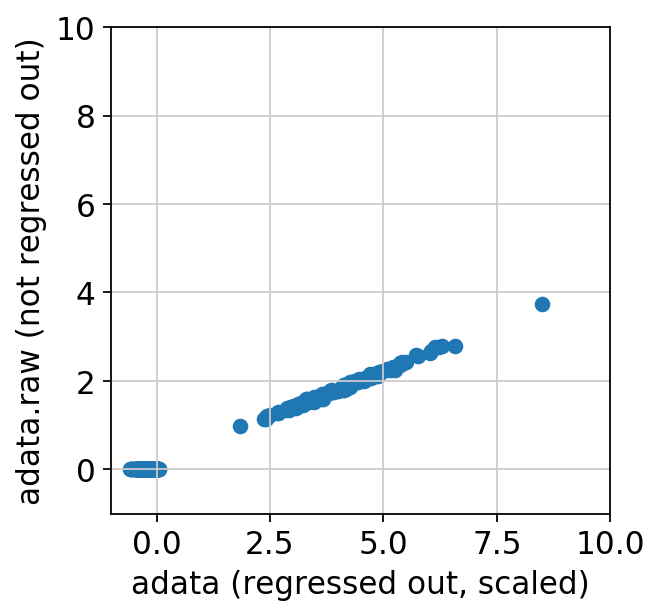

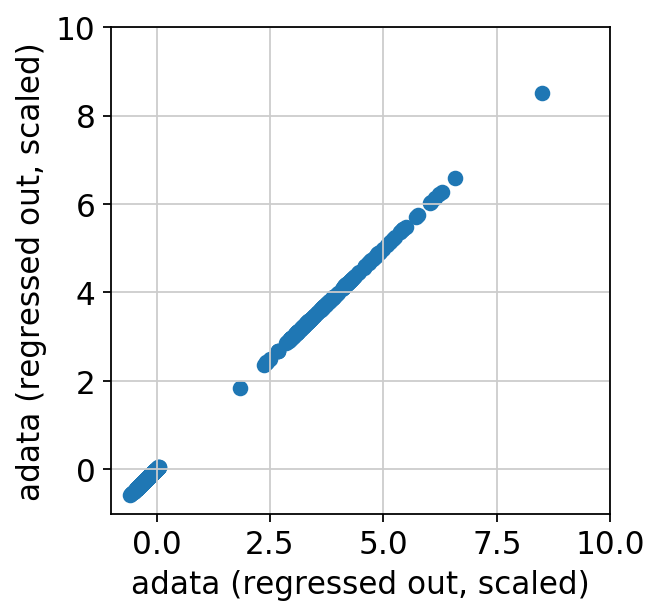

In [197]:
plt.scatter(np.array(adata[:,gene_x].X),np.array(adata.raw[:,gene_x].X))
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata.raw (not regressed out)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()

plt.scatter(np.array(adata[:,gene_x].X),np.array(adata[:,gene_x].X))
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata (regressed out, scaled)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()

In [198]:
adata.write(results_file)

Reading in the saved data
===

When we read in the saved data, do we also get adata.raw?

In [200]:
adata2 = sc.read(results_file)
adata2

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [201]:
adata2.raw

Yes! Yaaaaaaay!

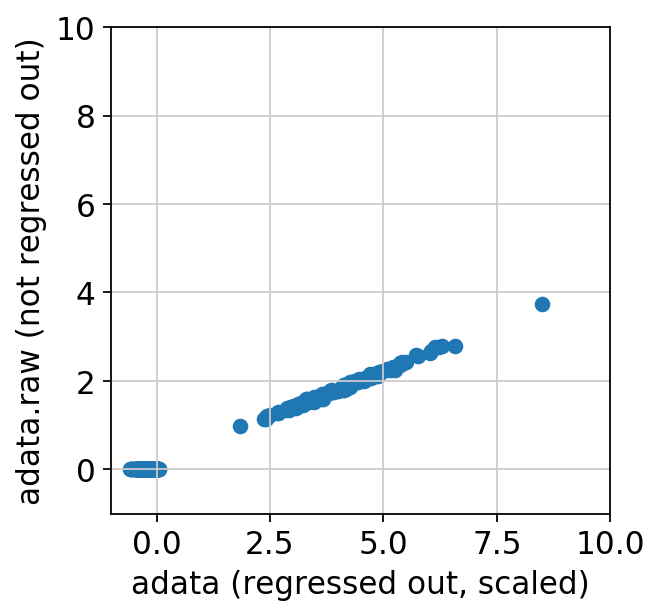

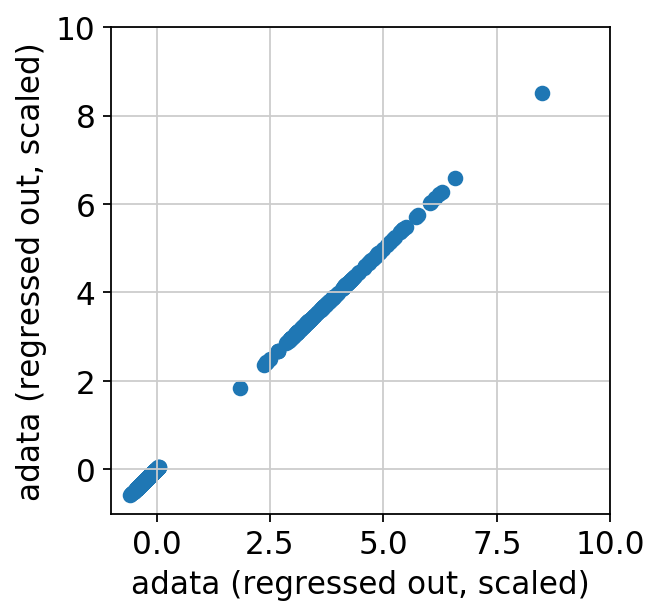

In [202]:
gene_x='TNFRSF4'

plt.scatter(np.array(adata2[:,gene_x].X),np.array(adata2.raw[:,gene_x].X))
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata.raw (not regressed out)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()

plt.scatter(np.array(adata2[:,gene_x].X),np.array(adata2[:,gene_x].X))
plt.xlabel('adata (regressed out, scaled)')
plt.ylabel('adata (regressed out, scaled)')
plt.xlim(-1,10)
plt.ylim(-1,10)
plt.show()